# Apnea example

## Data description

The signals are grouped by signal. The different series are the different heights of the peaks.

5-12: CANN
12-19: MOUT
19-26: ABDO
26-33: THOR

For 5-12, we expect first a high peak, then lower peaks (or no peaks because of lack of breathing) and then a high peak again.
Different between apnea and hypopnea is no breathing (5) vs shallow breathing (>=6).

1-2: apnea
3-4: hypopnea

In [1]:
import os
from pathlib import Path
from eventwarping.formats import setlistfile2setlistsfile
from eventwarping.eventseries import EventSeries
from eventwarping.constraints import *
from IPython.display import HTML, display
import numpy as np
import tqdm

In [2]:
import configparser
config = configparser.ConfigParser()
pytest_fn = Path(".") / ".." / "tests" / "pytest.ini"
if pytest_fn.exists():
    print("Usign settings from pytest.ini file")
    config.read(str(pytest_fn))
    try:
        for line in config['pytest']['env'].split():
            parts = line.partition("=")
            if parts[0] == 'TESTDIR':
                directory = Path(parts[2])
                if not directory.exists():
                    print(f"Directory does not exist: {directory}")
    except Exception as exc:
        directory = Path(".")
else:
    directory = Path(".")
print(f"Using output directory: {directory}")

Usign settings from pytest.ini file
Using output directory: /Users/wannes/Desktop/debug


## Create series file

Create a file with the series that are apnea (based on start and stop symbols).

In [3]:
# folder where apnea data is stored
folder = Path(".") / ".." / "tests" / "rsrc" / "apnea"
# fn = folder / "MST_M03_0004086_itemsets.txt"  # 3 and ~70 occurrences
fn = folder / "DZ_00001_0000207#01_itemsets.txt"  # 201 and 47 occurrences
# fn = folder / "DZ_DZ1_0000003#01_itemsets.txt"  # 1  and ?? occurrences
fn_to = fn.parent / (fn.stem + "_series.txt")
if not fn_to.exists():
    print(f"Create new examples from: {fn} (exists={fn.exists()}")
    print(f"Saving to {fn_to}")
    setlistfile2setlistsfile(fn, fn_to, start={1, 3}, stop={2, 4}, margin=3)
else:
    print(f"Already exists, not creating:{fn_to}")

Already exists, not creating:../tests/rsrc/apnea/DZ_00001_0000207#01_itemsets_series.txt


## Align events

In [4]:
constraints = [
    MaxMergeSymbolConstraint(2),
    NoXorMergeSymbolSetConstraint(range(5, 12)),
    NoXorMergeSymbolSetConstraint(range(12, 19)),
    NoXorMergeSymbolSetConstraint(range(19, 26)),
    NoXorMergeSymbolSetConstraint(range(26, 33))]
es_o = EventSeries.from_setlistfile(fn_to, window=5, intonly=True, constraints=constraints)
es_o.insert_spacers(1)
es_a = es_o.copy(filter_symbols=[1,2])
es_h = es_o.copy(filter_symbols=[3,4])
idxs = {idx: np.where(es_o.series[:, :, idx] > 0) for idx in [1, 2, 3, 4]}
es_o.series[idxs[1][0], idxs[1][1], 3] = 1
es_o.series[idxs[2][0], idxs[2][1], 4] = 1
es_o.series[idxs[3][0], idxs[3][1], 1] = 1
es_o.series[idxs[4][0], idxs[4][1], 2] = 1
ess = {'o': es_o, 'a': es_a, 'h': es_h}
for key, es in ess.items():
    print(f"es_{key}.series.shape={es.series.shape}")
# Prefer to group initial / end states
for symbol in [1, 2, 3, 4]:
    for es in ess.values():
        es.rescale_weights[symbol] = 5

# s = es.format_series()
# Show initial series
# HTML(f"""
# <style>div.fmt pre {{white-space: pre;}}</style>
# <div class="fmt"><pre>{s}</pre></div>
# """)

es_o.series.shape=(191, 35, 39)
es_a.series.shape=(146, 35, 39)
es_h.series.shape=(45, 35, 39)


In [5]:
# Warp and show intermediate warpings
# for i, ws in enumerate(es.warp_yield(iterations=3, restart=True)):
#     print(f"=== {i+1:>2} ===")
#     s = es.format_warped_series()
#     display(HTML(f"""
#     <style>div.fmt pre {{white-space: pre;}}</style>
#     <div class="fmt"><pre>{s}</pre></div>
#     """))

In [6]:
for i in tqdm.trange(15):
    for key, es in ess.items():
        es.warp(plot={'symbol': {3,4,5}, 'seriesidx': 2, 'filename': str(directory / f"gradients_{key}_{i}.png")})
        es.plot_symbols(filename=str(directory / f"symbols_{key}_{i+1}.png"))

for key, es in ess.items():
    es.plot_symbols(filename=str(directory / f"symbols_{key}.png"))
    np.save(str(directory / f"series_{key}.npy"), es.warped_series)
    s = es.warped_series * es._smoothed_counts.T[np.newaxis, :, :]
    np.save(str(directory / f"seriesw_{key}.npy"), s)

100%|██████████| 15/15 [00:58<00:00,  3.87s/it]


In [17]:
# Correct starts and stops back to the original
es_o._warped_series[idxs[1][0], :, 3] = 0
es_o._warped_series[idxs[2][0], :, 4] = 0
es_o._warped_series[idxs[3][0], :, 1] = 0
es_o._warped_series[idxs[4][0], :, 2] = 0

In [20]:
es_o.plot_symbols(filename=str(directory / f"symbols_o2.png"), filter_symbols=None)
es_o.plot_symbols(filename=str(directory / f"symbols_o_a.png"), filter_symbols=[1])
es_o.plot_symbols(filename=str(directory / f"symbols_o_h.png"), filter_symbols=[3])

## Results

In [82]:
from sklearn.cluster import SpectralCoclustering
from scipy.spatial.distance import hamming
from sklearn.metrics.pairwise import cosine_similarity
from sklearn_extra.cluster import KMedoids
from collections import Counter
import matplotlib.pyplot as plt

In [83]:
# s = np.load("/Users/wannes/Desktop/debug/series.npy")
# ss = np.sign(s)

ss = np.load("/Users/wannes/Desktop/debug/seriesw.npy")
c1 = np.where(ss[:, :, 1] > 0)[0]
c3 = np.where(ss[:, :, 3] > 0)[0]
labels = ss[:,:,:5].copy()
ss[:,:,:5] = 0 # the start/end are weighed too high  (and are the labels)

ssr = ss.reshape((ss.shape[0], ss.shape[1]*ss.shape[2]))

In [84]:
c1.shape, c3.shape, ss.shape, ssr.shape

((146,), (45,), (191, 35, 39), (191, 1365))

In [86]:
n_clusters = 6
def mymetric(a, b):
    return cosine_similarity(np.atleast_2d(a), np.atleast_2d(b))[0]
kmedoids = KMedoids(n_clusters=n_clusters, metric=mymetric, random_state=0).fit(ssr)

/Users/wannes/Projects/Research/2023-EventWarping/venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
/Users/wannes/Projects/Research/2023-EventWarping/venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
/Users/wannes/Projects/Research/2023-EventWarping/venv/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:297: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [87]:
c = Counter(kmedoids.labels_)
c

Counter({0: 92, 3: 50, 5: 32, 2: 9, 4: 4, 1: 4})

In [88]:
Counter(kmedoids.labels_[c1])

Counter({0: 72, 3: 40, 5: 23, 2: 5, 1: 4, 4: 2})

In [89]:
Counter(kmedoids.labels_[c3])

Counter({0: 20, 3: 10, 5: 9, 2: 4, 4: 2})

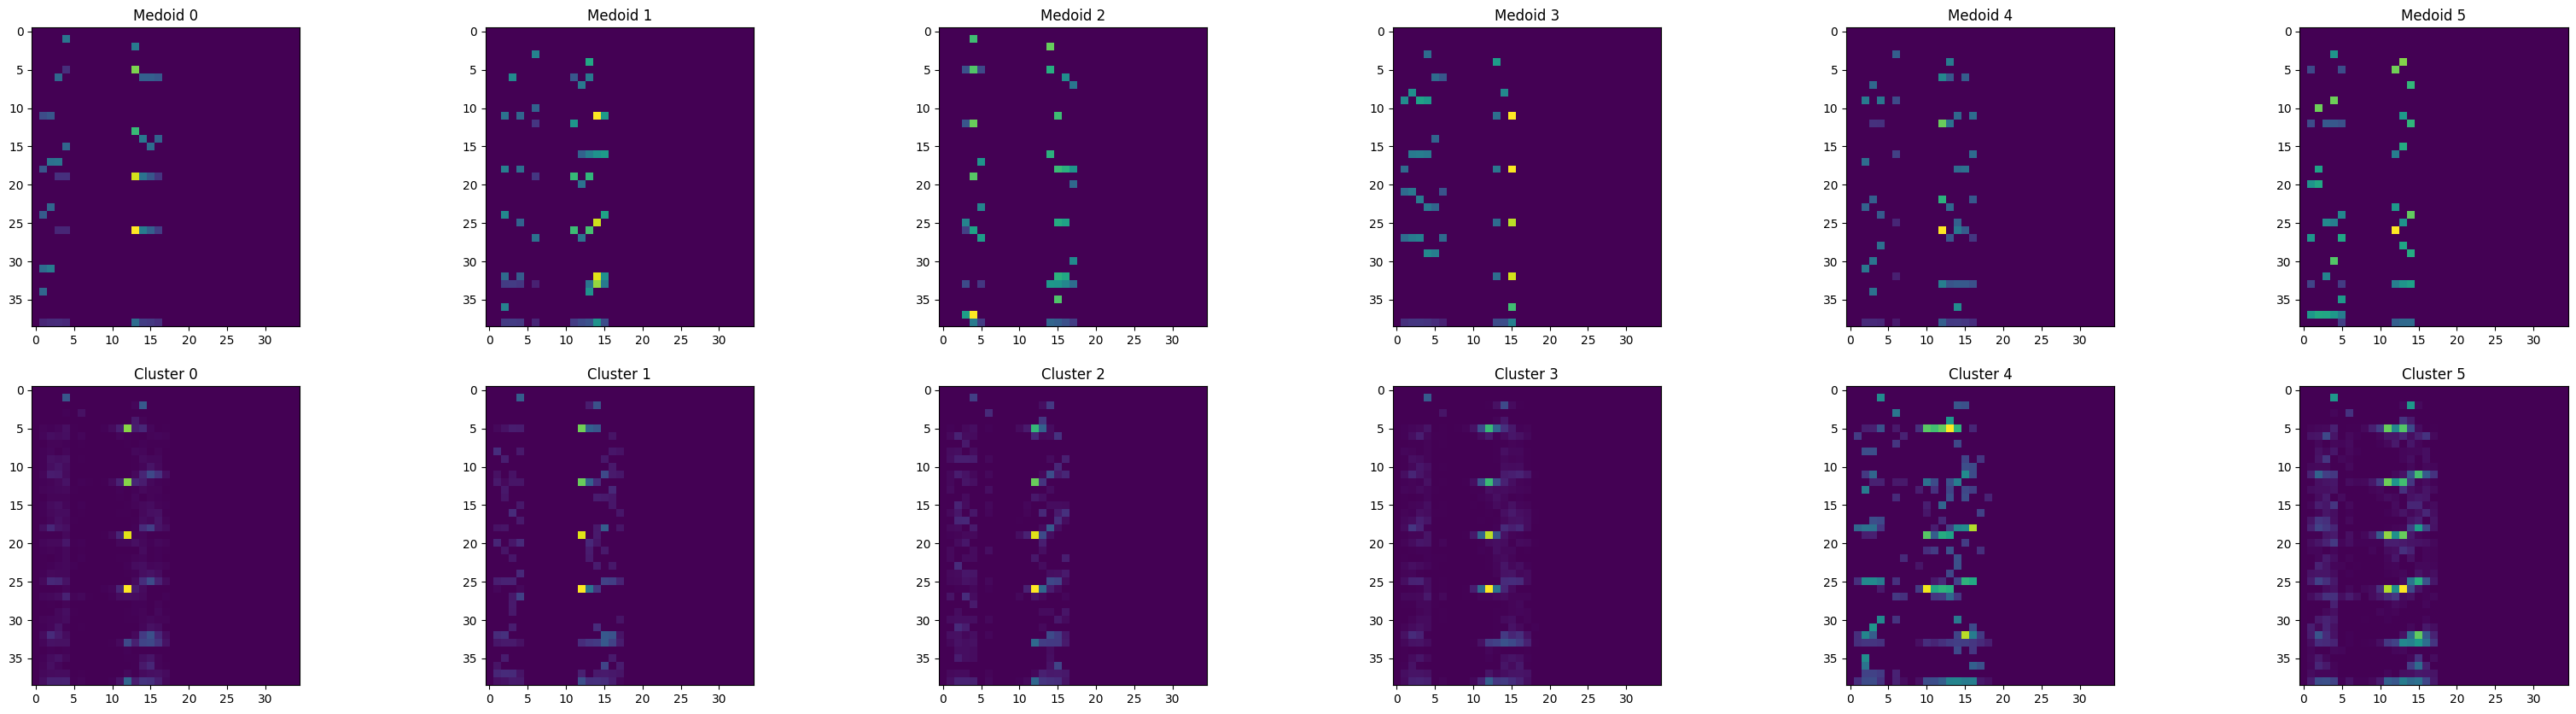

In [90]:
ss[:,:,:5] = labels/10

fig, axs = plt.subplots(nrows=2, ncols=n_clusters, figsize=(40,10))
for clidx in range(n_clusters):
    if clidx not in c:
        continue
    medoididx = kmedoids.medoid_indices_[clidx]
    axs[0, clidx].imshow(ss[medoididx].T)
    axs[0, clidx].set_title(f"Medoid {clidx}")
    axs[1, clidx].imshow(ss[kmedoids.labels_ == clidx, :, :].sum(axis=0).T)
    axs[1, clidx].set_title(f"Cluster {clidx}")

In [91]:
fig.savefig(directory / "clusters.png")

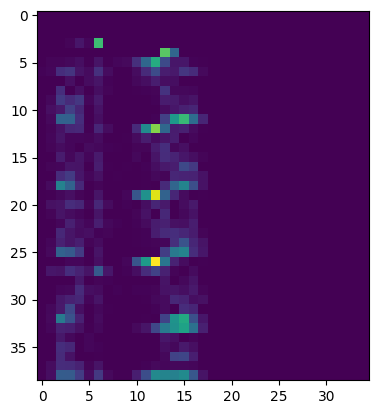

In [92]:
plt.imshow(ss[c3,:,:].sum(axis=0).T)

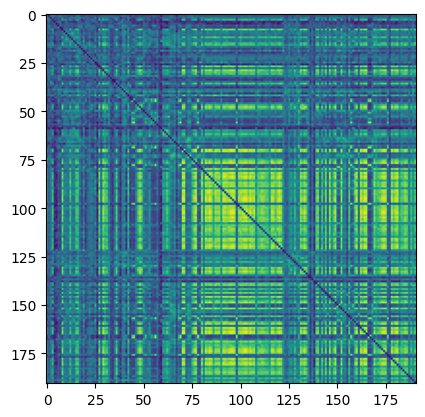

In [103]:
nb_series = ssr.shape[0]
dists = np.zeros((nb_series, nb_series))
for r in range(nb_series):
    for c in range(r+1, nb_series):
        # d = hamming(ssr[r,:], ssr[c,:])
        d = cosine_similarity(np.atleast_2d(ssr[r,:]), np.atleast_2d(ssr[c,:]))[0][0]
        dists[r,c] = d
        dists[c,r] = d

for r in c1:
    dists[r,r] = 0
plt.imshow(dists)

## Patterns

In [104]:
from sequential.seq2pat import Seq2Pat, Attribute
from sequential.dpm import dichotomic_pattern_mining, DichotomicAggregation

In [105]:
# s = np.load(directory / "series.npy")
# ss = np.sign(s)

ss = np.load(directory / "seriesw.npy")

ssr = ss.reshape((ss.shape[0], ss.shape[1]*ss.shape[2]))

In [106]:
# TODO: remove less important symbols (only retain high frequent symbols to speed up pattern mining)
# TODO: use dichotomic_pattern_mining to discern between the two apnea types
threshold = 0
sequences = []
for rowidx in range(ss.shape[0]):
    seq = []
    for eventidx in range(ss.shape[1]):
        for symbolidx in range(ss.shape[2]):
            if ss[rowidx, eventidx, symbolidx] > threshold:
                seq.append(symbolidx)
    sequences.append(seq)


In [107]:
seq2pat = Seq2Pat(sequences=sequences)

In [108]:
patterns = seq2pat.get_patterns(min_frequency=30)

In [109]:
# Filter patterns that have start/stop
p12, p34 = [], []
for pattern in patterns:
    for symbol in pattern:
        if symbol in [1,2]:
            p12.append(pattern)
            continue
        if symbol in [3,4]:
            p34.append(pattern)
            continue
print(f"Found {len(p12)} patterns with 1 or 2 and {len(p34)} with 3 or 4")

Found 1272 patterns with 1 or 2 and 16 with 3 or 4


In [110]:
p34

[[4, 38, 45],
 [38, 4, 45],
 [38, 4, 38, 45],
 [38, 38, 4, 43],
 [3, 38, 40],
 [38, 3, 38],
 [38, 3, 38, 38],
 [38, 38, 3, 38],
 [4, 11, 35],
 [38, 4, 11, 35],
 [4, 25, 32],
 [4, 38, 11, 32],
 [12, 4, 32],
 [12, 38, 4, 32],
 [38, 4, 38, 11, 32],
 [3, 12, 31]]

In [111]:
quantile = 0.99
if quantile < np.sum(ss == 0) / np.prod(ss.shape):
    print(f"Warning: Quantile threshold has no effect. There are more zeros than {quantile*100:.0f}%, use a number higher than {np.sum(ss == 0) / np.prod(ss.shape):.3f}")
threshold = np.quantile(ss, quantile)
print(f"Using threshold: {threshold}")
sequences_12 = []
sequences_34 = []
for rowidx in range(ss.shape[0]):
    seq = []
    is_12, is_34 = False, False
    for eventidx in range(ss.shape[1]):
        for symbolidx in range(ss.shape[2]):
            if ss[rowidx, eventidx, symbolidx] > threshold:
                if symbolidx in [1,2]:
                    is_12 = True
                elif symbolidx in [3,4]:
                    is_34 = True
                else:
                    # Don't include start-stop symbols, they are perfect discriminators
                    seq.append(symbolidx)
    if is_12:
        sequences_12.append(seq)
    elif is_34:
        sequences_34.append(seq)
    else:
        print(f"ERROR: no 12 or 34: {rowidx=}")
print(f"{len(sequences_12)=}")
print(f"{len(sequences_34)=}")

Using threshold: 0.07312166090200532
len(sequences_12)=146
len(sequences_34)=45


In [112]:
seq2pat_pos = Seq2Pat(sequences=sequences_12)
seq2pat_neg = Seq2Pat(sequences=sequences_34)
aggregation_to_patterns = dichotomic_pattern_mining(seq2pat_pos, seq2pat_neg,
                                                    min_frequency_pos=10,
                                                    min_frequency_neg=10)
print("Found # patterns:")
for key, val in aggregation_to_patterns.items():
    print(f"{key:>5}: {len(val)}")
dpm_patterns = aggregation_to_patterns[DichotomicAggregation.union]

Found # patterns:
intersection: 45
union: 2441
unique_negative: 0
unique_positive: 2396


In [113]:
max_len = max(len(p) for p in aggregation_to_patterns['unique_positive']) - 2
[p for p in aggregation_to_patterns['unique_positive'] if len(p) >= max_len]

[[5, 12, 19, 5, 12, 19, 26],
 [5, 12, 19, 5, 12, 26, 11],
 [5, 12, 19, 26, 5, 12, 11],
 [5, 12, 19, 26, 5, 12, 19],
 [5, 12, 19, 26, 5, 12, 21],
 [5, 12, 19, 26, 5, 12, 26],
 [5, 12, 19, 26, 5, 19, 26],
 [5, 12, 19, 26, 5, 26, 11],
 [5, 12, 19, 26, 12, 19, 26],
 [5, 12, 19, 26, 12, 26, 11],
 [5, 12, 19, 26, 33, 5, 12],
 [5, 12, 19, 26, 33, 5, 12, 26],
 [5, 12, 19, 26, 33, 5, 26],
 [5, 12, 19, 26, 33, 12, 26],
 [5, 12, 19, 26, 33, 38, 5],
 [5, 12, 19, 26, 33, 38, 5, 12],
 [5, 12, 19, 26, 33, 38, 5, 12, 26],
 [5, 12, 19, 26, 33, 38, 5, 26],
 [5, 12, 19, 26, 33, 38, 11],
 [5, 12, 19, 26, 33, 38, 12],
 [5, 12, 19, 26, 33, 38, 12, 26],
 [5, 12, 19, 26, 33, 38, 26],
 [5, 12, 19, 26, 33, 38, 35],
 [5, 12, 19, 26, 33, 38, 36],
 [5, 12, 19, 26, 38, 5, 11],
 [5, 12, 19, 26, 38, 5, 12],
 [5, 12, 19, 26, 38, 5, 12, 26],
 [5, 12, 19, 26, 38, 5, 19],
 [5, 12, 19, 26, 38, 5, 19, 26],
 [5, 12, 19, 26, 38, 5, 26],
 [5, 12, 19, 26, 38, 12, 26],
 [5, 12, 19, 26, 38, 19, 26],
 [5, 12, 19, 26, 38, 26, 11],

In [114]:
aggregation_to_patterns['unique_negative']

[]